In [193]:
import pandas as pd
from mne import create_info
from mne.io import RawArray
import  mne
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

### Concatenating raw files

In [194]:
# sunsun_file = r"C:\Users\bci\Documents\projects\hybrid-ssvep-p300-speller\three_flicker\record\sunsun_20230411\sunsun_20230411.fif"
# sunsun_file_v2 = r"C:\Users\bci\Documents\projects\hybrid-ssvep-p300-speller\three_flicker\record\sunsun_20230423\sunsun_20230423.fif"
# wan_file = r"C:\Users\bci\Documents\projects\hybrid-ssvep-p300-speller\three_flicker\record\wan_20230421\wan_20230421.fif"
# anagha_file = r"C:\Users\bci\Documents\projects\hybrid-ssvep-p300-speller\three_flicker\record\anagha_20230421\anagha_20230421.fif"

# raws = []
# fnames = [sunsun_file, wan_file, anagha_file, sunsun_file_v2]

# for fname in fnames:
#     raw = mne.io.read_raw_fif(fname, preload=True)
#     new_data = raw.get_data()[:,10*250:-10*250]
#     raw_new = mne.io.RawArray(new_data, raw.info)
#     raws.append(raw_new)

# raw = mne.concatenate_raws(raws)
# raw.notch_filter([50,100], trans_bandwidth = 3)
# raw.filter(4,77)
# raw.compute_psd().plot()

Opening raw data file E:\Thesis\HybridSpeller\three_flicker\record\vineet_20230423\vineet_20230423.fif...
    Range : 0 ... 27910 =      0.000 ...   111.640 secs
Ready.
Reading 0 ... 27910  =      0.000 ...   111.640 secs...
Creating RawArray with float64 data, n_channels=9, n_times=22911
    Range : 0 ... 22910 =      0.000 ...    91.640 secs
Ready.
Effective window size : 1.024 (s)


C:\Users\Sunsun\AppData\Local\Temp\ipykernel_3976\3877541527.py:3: RuntimeWarning: This filename (E:\Thesis\HybridSpeller\three_flicker\record\vineet_20230423\vineet_20230423.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw =  mne.io.read_raw_fif(fname,  preload = True)
c:\Users\Sunsun\.virtualenvs\HybridSpeller-q8UBACmb\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


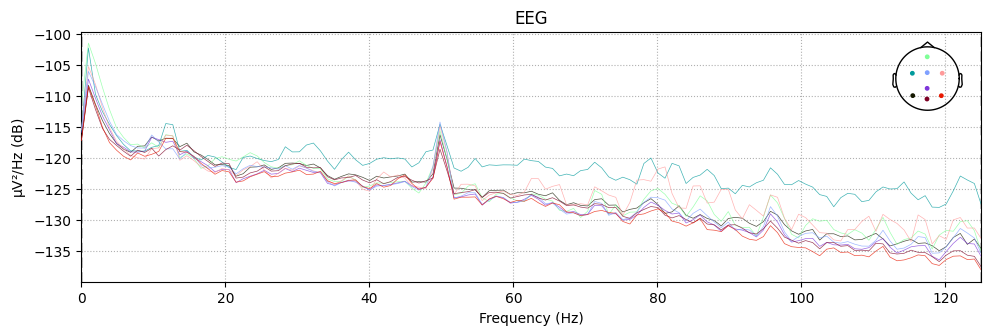

In [195]:
fname = r"E:\Thesis\HybridSpeller\three_flicker\record\vineet_20230423\vineet_20230423.fif"

raw =  mne.io.read_raw_fif(fname,  preload = True)
new_data = raw.get_data()[:,10*250:-10*250]
new_data[:8,:]  = new_data[:8,:] * 1e-6
raw = mne.io.RawArray(new_data, raw.info)


# b,a = signal.iirfilter(10, Wn=[7, 90],  btype='band', analog=False, fs=250,  ftype='butter')

# filt = signal.filtfilt(b,a,x,axis=1)

# raw_new.notch_filter([50,100], trans_bandwidth = 3)
# raw_new.filter(4,77)
# raw_new.compute_psd().plot()
# raw.notch_filter([50], trans_bandwidth = 3)
# raw.filter(7,90)
raw.compute_psd().plot()

In [196]:
# pick channels from raw
# picked_channels = ['PO7', 'Oz', 'PO8', 'STIM MARKERS']

# raw.pick_channels(picked_channels)
# raw.ch_names

In [197]:
events = mne.find_events(raw, initial_event = True)
tmin, tmax = 1, 5 - 1/250  # in s
baseline = None
epochs = mne.Epochs(
    raw, events=events,tmin=tmin,
    tmax=tmax, baseline=baseline, verbose=False)


X = epochs.get_data()[:, :-1, :]
y = epochs.events[:, -1]


b,a = signal.iirfilter(10, Wn=[7, 90],  btype='band', analog=False, fs=250,  ftype='butter')
X = signal.filtfilt(b,a,X,axis=2)
epochs.load_data()
epochs._data[:, :-1, :] = X

epochs.compute_psd().plot()




X = epochs.get_data()[:, :-1, :]
y = epochs.events[:, -1]

14 events found
Event IDs: [1 2 3]
Using data from preloaded Raw for 14 events and 1000 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 13 events and 1000 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


c:\Users\Sunsun\.virtualenvs\HybridSpeller-q8UBACmb\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


In [198]:
print(X.shape)
print(y.shape)

(13, 8, 1000)
(13,)


In [199]:
y

array([2, 1, 3, 2, 1, 3, 2, 1, 3, 2, 1, 3, 2], dtype=int64)

In [200]:
from numpy import ndarray
import numpy as np
from scipy.sparse import vstack, identity, spmatrix
from typing import Optional, cast, Union
from scipy.linalg import eigh
from scipy.sparse.linalg import eigsh
from scipy.stats import pearsonr
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from joblib import Parallel, delayed
from functools import partial



def _ged_wong(
    Z: ndarray,
    D: Optional[ndarray] = None,
    P: Optional[ndarray] = None,
    n_components=1,
    method="type1",
):
    if method != "type1" and method != "type2":
        raise ValueError("not supported method type")

    A = Z
    if D is not None:
        A = D.T @ A
    if P is not None:
        A = P.T @ A
    A = A.T @ A
    if method == "type1":
        B = Z
        if D is not None:
            B = D.T @ Z
        B = B.T @ B
        if isinstance(A, spmatrix) or isinstance(B, spmatrix):
            D, W = eigsh(A, k=n_components, M=B)
        else:
            D, W = eigh(A, B)
    elif method == "type2":
        if isinstance(A, spmatrix):
            D, W = eigsh(A, k=n_components)
        else:
            D, W = eigh(A)

    D_exist = cast(ndarray, D)
    ind = np.argsort(D_exist)[::-1]
    D_exist, W = D_exist[ind], W[:, ind]
    return D_exist[:n_components], W[:, :n_components]


def _trca_kernel(X: ndarray):
    """TRCA.
    X: (n_trials, n_channels, n_samples)
    """
    X = np.reshape(X, (-1, *X.shape[-2:]))
    M, C, N = X.shape
    n_components = C
    P = vstack([identity(N) for _ in range(M)])
    P = P @ P.T
    # P = abs(P @ P.T)
    Z = np.hstack(X).T  # type: ignore
    _, U = _ged_wong(Z, None, P, n_components=n_components)  # U for X
    return U


def _trca_feature(
    X: ndarray,
    templates: ndarray,
    Us: ndarray,
    n_components: int = 1,
    ensemble: bool = True,
):
    rhos = []
    if not ensemble:
        for Xk, U in zip(templates, Us):
            a = U[:, :n_components].T @ X
            b = U[:, :n_components].T @ Xk
            a = np.reshape(a, (-1))
            b = np.reshape(b, (-1))
            rhos.append(pearsonr(a, b)[0])
    else:
        U = Us[:, :, :n_components]
        U = np.concatenate(U, axis=-1)
        for Xk in templates:
            a = U.T @ X
            b = U.T @ Xk
            a = np.reshape(a, (-1))
            b = np.reshape(b, (-1))
            rhos.append(pearsonr(a, b)[0])
    return rhos


class TRCA(BaseEstimator, TransformerMixin, ClassifierMixin):
    def __init__(
        self, n_components: int = 1, ensemble: bool = True, n_jobs: Optional[int] = None
    ):
        self.n_components = n_components
        self.ensemble = ensemble
        self.n_jobs = n_jobs

    def fit(self, X: ndarray, y: ndarray, Yf: Optional[ndarray] = None):
        self.classes_ = np.unique(y)
        X = np.reshape(X, (-1, *X.shape[-2:]))
        X = X - np.mean(X, axis=-1, keepdims=True)
        self.templates_ = np.stack(
            [np.mean(X[y == label], axis=0) for label in self.classes_]
        )

        self.Us_ = np.stack([_trca_kernel(X[y == label]) for label in self.classes_])
        return self

    def transform(self, X: ndarray):
        X = np.reshape(X, (-1, *X.shape[-2:]))
        X = X - np.mean(X, axis=-1, keepdims=True)
        n_components = self.n_components
        templates = self.templates_
        Us = self.Us_
        ensemble = self.ensemble
        rhos = Parallel(n_jobs=self.n_jobs)(
            delayed(
                partial(
                    _trca_feature, Us=Us, n_components=n_components, ensemble=ensemble
                )
            )(a, templates)
            for a in X
        )
        rhos = np.stack(rhos)
        return rhos

    def predict(self, X: ndarray):
        feat = self.transform(X)
        labels = self.classes_[np.argmax(feat, axis=-1)]
        return labels


def generate_cca_references(
    freqs,
    srate,
    T,
    phases: Optional[Union[ndarray, int, float]] = None,
    n_harmonics: int = 1,
):
    if isinstance(freqs, int) or isinstance(freqs, float):
        freqs = [freqs]
    freqs = np.array(freqs)[:, np.newaxis]
    if phases is None:
        phases = 0
    if isinstance(phases, int) or isinstance(phases, float):
        phases = np.array([phases])
    phases = np.array(phases)[:, np.newaxis]
    t = np.linspace(0, T, int(T * srate))

    Yf = []
    for i in range(n_harmonics):
        Yf.append(
            np.stack(
                [
                    np.sin(2 * np.pi * (i + 1) * freqs * t + np.pi * phases),
                    np.cos(2 * np.pi * (i + 1) * freqs * t + np.pi * phases),
                ],
                axis=1,
            )
        )
    Yf = np.concatenate(Yf, axis=1)
    return Yf

In [201]:
model=TRCA(n_components = 3, n_jobs=-1)
model.fit(X, y)

TRCA(n_components=3, n_jobs=-1)

In [202]:
# from sklearn.utils import shuffle
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import StratifiedKFold

# skf = StratifiedKFold(n_splits=5)
# skf.get_n_splits(X, y)
# print(skf)
# accs = []
# for i, (train_index, test_index) in enumerate(skf.split(X, y)):
#     print(f"Fold {i}:")
#     print(f"  Train: ", y[train_index])
#     print(f"  Test: ", y[test_index])
#     model=TRCA(n_components = 1, n_jobs=-1)
#     model.fit(X[train_index], y[train_index])
#     preds = model.predict(X[test_index])
#     acc = np.mean(preds == y[test_index])
#     accs.append(acc)
#     print(y[test_index])
#     print(preds)
#     print(acc)
# print("Average accuracy ==>", np.mean(accs))


In [203]:
# from sklearn.model_selection import StratifiedKFold

# estimator=TRCA(n_components = 1, n_jobs=-1)
# skf = StratifiedKFold(n_splits=5)
# skf.get_n_splits(X, y)
# print(skf)
# accs = []
# for i, (train_index, test_index) in enumerate(skf.split(X, y)):
#     print(f"Fold {i}:")
#     print(f"  Train: ", y[train_index])
#     print(f"  Test: ", y[test_index])
#     model = estimator.fit(X[train_index], y[train_index])
#     preds = model.predict(X[test_index])
#     acc = np.mean(preds == y[test_index])
#     accs.append(acc)
#     print(y[test_index])
#     print(preds)
#     print(acc)
# print("Average accuracy ==>", np.mean(accs))


In [204]:
import pickle

filename = 'TRCA_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [205]:
print(model)

TRCA(n_components=3, n_jobs=-1)
